### Reinforcement Learning - Resource Manager

Kudos to:

https://www.gymlibrary.dev/content/environment_creation/

https://www.youtube.com/watch?v=bD6V3rcr_54&ab_channel=NicholasRenotte 

Version 1.2:

- Implement Monte Carlo search Tree



### Imports

In [1]:
import gym
from gym import spaces
import numpy as np
import pygame
from gym.envs.registration import register
import matplotlib.pyplot as plt

### Environment

In [2]:
from ResourceManagerEnvironment_MCTS import ResourceManagerEnv

In [3]:
#register the environment
register(
    id='Resource-Manager-v1-2',
    #loading syntax: 'PythonFileName:EnvironmentClassName'
    entry_point='ResourceManagerEnvironment_MCTS:ResourceManagerEnv',
    max_episode_steps=300,
)


In [4]:
env = gym.make('Resource-Manager-v1-2')

c:\Users\denni\.conda\envs\tf\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 10)
  logger.warn(


## Monte Carlo Tree Search

In [26]:
import numpy as np

class Node:
    def __init__(self, state, parent=None, action=None):
        #state of the environment
        self.state = state
        #parent node
        self.parent = parent
        #action that led to this node
        self.children = []
        #number of times this node was visited
        self.visits = 0
        #total reward of this node
        self.value = 0.0
        #action that led to this node
        self.action = action

class MonteCarloTreeSearch:
    def __init__(self, env, iterations=1000, simulation_steps=10):
        self.env = env
        self.root = Node(state=env.reset())
        self.iterations = iterations
        self.simulation_steps = simulation_steps

    def select(self, node):
        while node.children:
            #UCB1 algorithm --> https://www.turing.com/kb/guide-on-upper-confidence-bound-algorithm-in-reinforced-learning
            node = max(node.children, key=lambda child: child.value / (child.visits + 1e-4))
        return node

    def expand(self, node):
        actions = np.arange(4)
        new_node = None
        for action in actions:
            try:
                state,  reward, terminated, truncated, info = self.env.step(action)
                new_state = self.env.get_obs()
                new_node = Node(state=new_state, parent=node, action=action)
                node.children.append(new_node)
            except Exception as e:
                print(f"Error in expand function for action {action}: {e}")
        return new_node


    def simulate(self, node):
        total_reward = 0
        for _ in range(self.simulation_steps):
            action = np.random.randint(4)  # Random action
            #needed for troubleshooting
            #result = self.env.step(action)
            #print(result)
            state, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            if terminated:
                self.env.reset()
                break
        return total_reward
    
    def get_best_action(self):
        if not self.root.children:
            return np.random.randint(4)  # If no children, return a random action

        # Select the action with the highest value
        best_action = max(self.root.children, key=lambda child: child.value).action
        return best_action


    def backpropagate(self, node, reward):
        while node is not None:
            node.visits += 1
            node.value += reward
            node = node.parent

    def search(self, action=None):
        for _ in range(self.iterations):
            selected_node = self.select(self.root)
            new_node = self.expand(selected_node)
            simulation_result = self.simulate(new_node)
            #state, reward, done = self.env.step(action)  # Ignore info during expansion
            #new_state = self.env.get_obs()  # Assuming get_obs provides the new state
            #new_node = Node(state=new_state, parent=selected_node, action=action)
            self.backpropagate(new_node, simulation_result)
        best_action = self.get_best_action()
        return best_action



In [22]:
#Output I get

'''

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 0, False, {'agent_position': array([2, 1], dtype=int64), 'target_position': array([1, 4], dtype=int64), 'total_reward': 0}

'''

"\n\n[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], 0, False, {'agent_position': array([2, 1], dtype=int64), 'target_position': array([1, 4], dtype=int64), 'total_reward': 0}\n\n"

In [28]:
mcts = MonteCarloTreeSearch(env, iterations=1000, simulation_steps=10)
num_episodes = 100
total_rewards = []

for episode in range(num_episodes):
    #reset the environment for a new episode
    state = env.reset()

    #initialize the root node with the current state
    root = Node(state=state)

    #perform the search and get the best action
    best_action = mcts.search()

    #perform the selected action in the environment
    new_state, reward, done, truncated, info = env.step(best_action)

    total_rewards.append(info['total_reward'])

    print(f"Episode {episode + 1}, Total Reward: {info['total_reward']}")

    


Episode 1, Total Reward: -128
Episode 2, Total Reward: -43
Episode 3, Total Reward: -46
Episode 4, Total Reward: -118
Episode 5, Total Reward: -114
Episode 6, Total Reward: -161
Episode 7, Total Reward: -111
Episode 8, Total Reward: -100
Episode 9, Total Reward: -15
Episode 10, Total Reward: -157
Episode 11, Total Reward: -1
Episode 12, Total Reward: -195
Episode 13, Total Reward: -187
Episode 14, Total Reward: -65
Episode 15, Total Reward: -73
Episode 16, Total Reward: 0
Episode 17, Total Reward: -70
Episode 18, Total Reward: -42
Episode 19, Total Reward: -187
Episode 20, Total Reward: -117
Episode 21, Total Reward: -127
Episode 22, Total Reward: -192
Episode 23, Total Reward: -196
Episode 24, Total Reward: -111
Episode 25, Total Reward: -122
Episode 26, Total Reward: -23
Episode 27, Total Reward: -145
Episode 28, Total Reward: -56
Episode 29, Total Reward: -91
Episode 30, Total Reward: -77
Episode 31, Total Reward: -1
Episode 32, Total Reward: -13
Episode 33, Total Reward: -70
Episod

## Evaluation

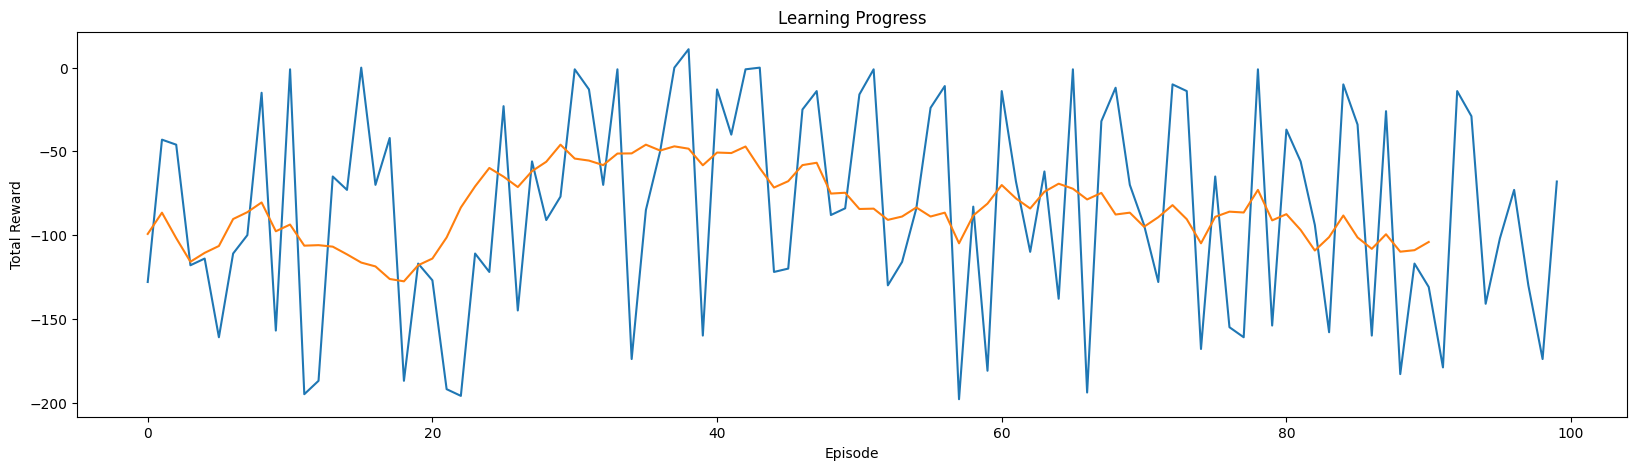

In [34]:
#Plot the total rewards
plt.figure(figsize=(20,5))
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Progress')
#plot tendency curve
plt.plot(np.convolve(total_rewards, np.ones((10,))/10, mode='valid'))
plt.show()
